In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import json
import seaborn as sns
from collections import Counter
import nltk
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

C:\Users\owltu\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\owltu\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

#### Data Cleaning

In [5]:
yelp = pd.read_csv("yelp_balanced.csv")

In [6]:
yelp

,Unnamed: 0,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,111089,S3r97tHMkzR4O-tiIIzwOQ,r0GLQAawvHXUd-xZow-fWQ,mzREMIknfmagJugibXrCsQ,4,2017-04-14,"Food is tasty, it's usually busy, but there al...",0,0,0
1,674606,lZTYcQXntUsLptcWCqyhmg,bDs5_ek9esUkgxFm1jFxfg,aZG9Hp8fdgzq37iuB1QTYg,1,2017-10-01,Probably one of the worst experiences I've eve...,1,0,0
2,3329480,sStohXbOEdPyrutK3zJSmg,mus1d8cMxuEJmP0zfV19hg,I4Nr-MVc26qWr08-S3Q1ow,4,2017-01-19,I was looking for a place to grab a quick bite...,0,0,0
3,3641542,Pvw7lbeyGGLVALvK0DwgDA,qrwH8z4nNUabqlsnwNoDCg,vAbRNF0hJt91oCUpm_sdKw,3,2014-01-09,"Meh, fish was a bit rubbery for $34 swordfish....",1,0,0
4,2054056,XWN8BVvLwcmgEW6xZuOKpg,cYvO88wNlRc_gd03caBZ7Q,sNVGdeOPeitJ3OWUQBINzQ,4,2012-02-29,I've heard so much about this place.. and I mu...,2,2,3
...,...,...,...,...,...,...,...,...,...,...
149995,4137925,-EfkdreWNtk2MsHYE-nv7Q,vRG_9sj-iFliiUKqZCVGRA,Rb2s2-2kIvbPXnPEuM_OBg,1,2015-06-13,Never ever will I dine or drink in this place ...,0,0,0
149996,2702734,VcLVmt3nMU4EW3D50SG2tA,NIeLhx7kQ7KROhH2zs5qYw,148d7J-cFejkhYV89y3Jsg,4,2010-11-28,It's 3.5 stars for me this time since the ride...,2,0,0
149997,4604320,D4EnQl1-Vgpfx0P-wxZM6w,RV0ljoUuwfkPYtzvT03W9g,sqFU1WIFbH_rrJJVHR4Z0g,5,2016-10-17,Good selection of produce at great prices. Gre...,1,0,0
149998,2349976,wGtYjLJL-O6TNA5EILPaLQ,4qyy_D9QSrRcGIrUekjXBw,75uWBy0mNnvSa6Wrrv7Xtg,5,2016-10-22,Absolutely no pressure!! We needed a quick ea...,0,0,0


In [7]:
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    return df

yelp = clean_text(yelp, 'text', 'text_clean')

In [8]:
yelp_basic = yelp[['stars', 'text_clean']]

In [9]:
yelp_basic.shape

(150000, 2)

In [10]:
yelp_features = yelp[['stars', 'text_clean', 'useful', 'funny', 'cool']]

In [11]:
df_train_raw, df_test = train_test_split(yelp_features, test_size=0.2, 
                                         random_state=42, shuffle=True)
df_train_raw, df_dev = train_test_split(df_train_raw, test_size=0.2,
                                        random_state=42, shuffle=True)

df_train = df_train_raw

In [12]:
def extract_features(df_train, df_dev, df_test):
    vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
    x_train = vectorizer.fit_transform(df_train.loc[:, 'text_clean'].values.astype('U'))
    x_dev = vectorizer.transform(df_dev.loc[:, 'text_clean'].values.astype('U'))
    x_test = vectorizer.transform(df_test.loc[:, 'text_clean'].values.astype('U'))
    y_train = df_train.loc[:, 'stars'].tolist()
    y_dev = df_dev.loc[:, 'stars'].tolist()
    y_test = df_test.loc[:, 'stars'].tolist()
    return x_train, x_dev, x_test, y_train, y_dev, y_test

In [13]:
def extract_features(df_train, df_dev, df_test, df_extra):
    vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
    x_train = vectorizer.fit_transform(df_train.loc[:, 'text_clean'].values.astype('U'))
    x_dev = vectorizer.transform(df_dev.loc[:, 'text_clean'].values.astype('U'))
    x_test = vectorizer.transform(df_test.loc[:, 'text_clean'].values.astype('U'))
    y_train = df_train.loc[:, 'stars'].tolist()
    y_dev = df_dev.loc[:, 'stars'].tolist()
    y_test = df_test.loc[:, 'stars'].tolist()
    
    x_contra = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['contradictory'] == 1].values.astype('U'))
    y_contra = df_extra.loc[:, 'stars'][df_extra['contradictory'] == 1].tolist()
    
    x_figurative = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['figurative'] == 1].values.astype('U'))
    y_figurative = df_extra.loc[:, 'stars'][df_extra['figurative'] == 1].tolist()

    x_qual = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['qualifier'] == 1].values.astype('U'))
    y_qual = df_extra.loc[:, 'stars'][df_extra['qualifier'] == 1].tolist()

    
    return x_train, x_dev, x_test, x_contra, x_figurative, x_qual, y_train, y_dev, y_test, y_contra, y_figurative, y_qual

In [14]:
#edge_features.loc[:, 'text_clean'][edge_features['contradictory'] == 1]

In [15]:
useful = df_train.loc[:, 'useful'].tolist()
funny = df_train.loc[:, 'funny'].tolist()
cool = df_train.loc[:, 'cool'].tolist()

#### Edge Case Import

In [16]:
edges = pd.read_csv("example_sentences.csv")
edges = clean_text(edges, 'text', 'text_clean')

In [17]:
edge_features = edges[['stars', 'text_clean', 'useful', 'funny', 'cool', 'contradictory', 'figurative', 'confusing', 'qualifier']]

In [18]:
#Feature extractor
def extract_edge_features(df_train):
    vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
    x_es = vectorizer.fit_transform(df_train.loc[:, 'text_clean'].values.astype('U'))
    y_es = df_train.loc[:, 'stars'].tolist()
    return x_es, y_es

In [19]:
x_train, x_dev, x_test, x_contra, x_figurative, x_qual, y_train, y_dev, y_test, y_contra, y_figurative, y_qual = extract_features(df_train, df_dev, df_test, edge_features)

In [20]:
x_test

<30000x165416 sparse matrix of type '<class 'numpy.float64'>'
	with 1982696 stored elements in Compressed Sparse Row format>

In [21]:
contra_set_x,contra_set_y = extract_edge_features(edge_features.loc[edge_features['contradictory'] == 1])
figurative_set_x,figurative_set_y = extract_edge_features(edge_features.loc[edge_features['figurative'] == 1])
qualifier_set_x,qualifier_set_y = extract_edge_features(edge_features.loc[edge_features['qualifier'] == 1])

#### Assess Model Performance

In [22]:
#Original
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
    if y_pred is None:
        y_pred = model.predict(X)

    print(label + ' Set')
    print("Accuracy:", accuracy_score(y, y_pred))
    print()

    print(classification_report(y, y_pred, digits=4))

    disp = plot_confusion_matrix(model, X, y, 
                               cmap=plt.cm.Blues, normalize='true')
    plt.savefig(model_name + "_" + label.lower() + ".eps")
    plt.show()
    print()

In [34]:
#Modified -- allow for saving star counts

#Original
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
    if y_pred is None:
        y_pred = model.predict(X)

    print(label + ' Set')
    print("Accuracy:", accuracy_score(y, y_pred))
    print()
    
    print(classification_report(y, y_pred, digits=4))

    disp = plot_confusion_matrix(model, X, y, 
                               cmap=plt.cm.Blues, normalize='true')
    plt.savefig(model_name + "_" + label.lower() + ".eps")
    plt.show()
    print()
    
    return (y,y_pred)


In [35]:
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
    mod_training = evaluate_model_Xy(model, x_train, y_train, label="Training", model_name=model_name)
    mod_valid = evaluate_model_Xy(model, x_dev, y_dev, label="Validation", model_name=model_name)
    mod_test = evaluate_model_Xy(model, x_test, y_test, label="Testing", model_name=model_name)
    mod_contradict = evaluate_model_Xy(model, x_contra, y_contra, label="Contradictory", model_name=model_name)
    mod_figurative = evaluate_model_Xy(model, x_figurative, y_figurative, label="Figurative", model_name=model_name)
    mod_qual = evaluate_model_Xy(model, x_qual, y_qual, label="Qualifiers", model_name=model_name)

    return (mod_training, mod_valid, mod_test, mod_contradict, mod_figurative, mod_qual)

#### Naive Bayes

In [ ]:
#Naive predictions


In [29]:
clf_nb = MultinomialNB(alpha=0.5,
                       fit_prior=True)
clf_nb.fit(x_train, y_train)


MultinomialNB(alpha=0.5)

Training Set
Accuracy: 0.7736458333333334

              precision    recall  f1-score   support

           1     0.7202    0.8051    0.7603     19222
           2     0.7490    0.7084    0.7281     19184
           3     0.8019    0.7625    0.7817     19146
           4     0.7465    0.8270    0.7847     19259
           5     0.8724    0.7650    0.8152     19189

    accuracy                         0.7736     96000
   macro avg     0.7780    0.7736    0.7740     96000
weighted avg     0.7779    0.7736    0.7740     96000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


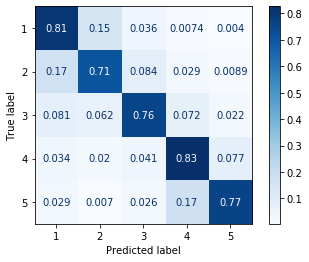


Validation Set
Accuracy: 0.549625

              precision    recall  f1-score   support

           1     0.6220    0.6988    0.6582      4867
           2     0.4694    0.4373    0.4527      4782
           3     0.4689    0.4516    0.4601      4867
           4     0.4832    0.5764    0.5257      4724
           5     0.7400    0.5836    0.6526      4760

    accuracy                         0.5496     24000
   macro avg     0.5567    0.5495    0.5499     24000
weighted avg     0.5566    0.5496    0.5499     24000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


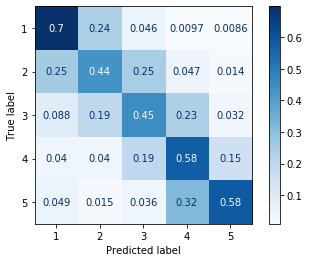


Testing Set
Accuracy: 0.5472

              precision    recall  f1-score   support

           1     0.6136    0.7037    0.6556      5883
           2     0.4807    0.4358    0.4572      6048
           3     0.4636    0.4500    0.4567      6009
           4     0.4825    0.5826    0.5278      6018
           5     0.7346    0.5677    0.6405      6042

    accuracy                         0.5472     30000
   macro avg     0.5550    0.5480    0.5475     30000
weighted avg     0.5548    0.5472    0.5471     30000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


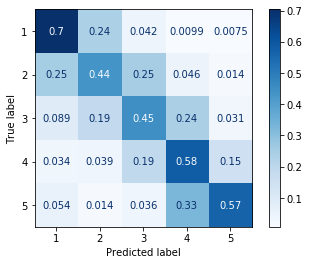


Contradictory Set
Accuracy: 0.5145631067961165

              precision    recall  f1-score   support

           1     0.5000    0.4000    0.4444        10
           2     0.6216    0.5750    0.5974        40
           3     0.5429    0.4872    0.5135        39
           4     0.2667    0.4444    0.3333         9
           5     0.3750    0.6000    0.4615         5

    accuracy                         0.5146       103
   macro avg     0.4612    0.5013    0.4700       103
weighted avg     0.5370    0.5146    0.5211       103



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


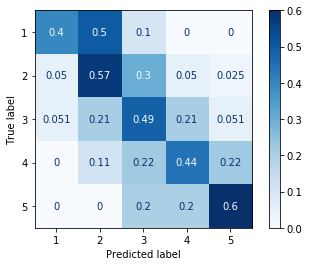


Figurative Set
Accuracy: 0.46296296296296297

              precision    recall  f1-score   support

           1     0.5000    0.5000    0.5000         6
           2     0.6000    0.5294    0.5625        17
           3     0.5000    0.4211    0.4571        19
           4     0.1818    0.3333    0.2353         6
           5     0.5000    0.5000    0.5000         6

    accuracy                         0.4630        54
   macro avg     0.4564    0.4568    0.4510        54
weighted avg     0.4961    0.4630    0.4752        54



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


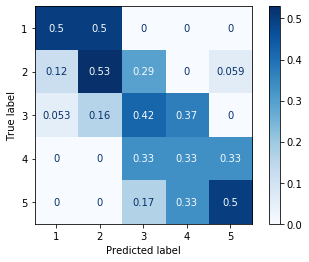


Qualifiers Set
Accuracy: 0.5405405405405406

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         1
           2     0.6667    0.5333    0.5926        15
           3     0.5500    0.6111    0.5789        18
           4     0.0000    0.0000    0.0000         1
           5     1.0000    0.5000    0.6667         2

    accuracy                         0.5405        37
   macro avg     0.4433    0.3289    0.3676        37
weighted avg     0.5919    0.5405    0.5579        37



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


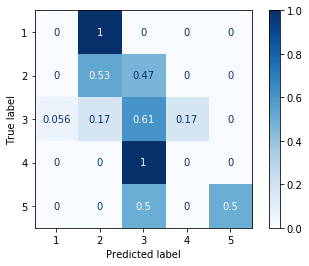

In [40]:
nb_model = evaluate_model(clf_nb, model_name="nb")

In [44]:
type(nb_model[1][0])

list

In [50]:
range(len(nb_model))

range(0, 6)

In [56]:
nb_mod_list = []*len(nb_model)
for i in range(len(nb_model)):
    nb_mod_list.append(np.asarray(nb_model[i]))

In [72]:
nb_mod_list

[array([[2, 5, 1, ..., 4, 5, 5],
        [2, 5, 1, ..., 4, 5, 4]]), array([[5, 1, 1, ..., 2, 1, 1],
        [5, 4, 1, ..., 4, 1, 1]]), array([[3, 2, 4, ..., 2, 4, 2],
        [3, 3, 4, ..., 1, 4, 3]]), array([[2, 2, 1, 2, 1, 5, 2, 2, 2, 3, 1, 1, 3, 2, 2, 5, 2, 2, 3, 3, 3, 3,
         2, 4, 3, 2, 2, 3, 2, 4, 2, 2, 3, 2, 4, 2, 3, 4, 3, 2, 3, 2, 2, 3,
         1, 3, 1, 2, 4, 2, 2, 2, 3, 3, 2, 1, 3, 2, 2, 2, 4, 2, 3, 3, 4, 1,
         5, 5, 3, 5, 4, 3, 3, 3, 2, 3, 4, 2, 3, 3, 1, 3, 3, 2, 3, 2, 3, 2,
         2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1],
        [3, 4, 1, 3, 2, 5, 2, 2, 2, 2, 1, 2, 3, 2, 2, 5, 2, 4, 4, 2, 1, 3,
         3, 4, 3, 2, 1, 4, 3, 4, 3, 2, 2, 2, 3, 2, 3, 5, 3, 3, 3, 2, 3, 4,
         2, 3, 2, 3, 4, 2, 3, 2, 3, 3, 1, 1, 4, 2, 3, 3, 2, 2, 3, 3, 5, 3,
         5, 3, 1, 4, 4, 3, 2, 3, 2, 4, 3, 2, 2, 5, 1, 2, 2, 2, 4, 2, 5, 2,
         5, 4, 2, 2, 2, 3, 3, 2, 4, 3, 3, 3, 3, 3, 2]]), array([[2, 4, 2, 4, 1, 3, 4, 3, 4, 5, 3, 1, 2, 1, 2, 2, 2, 2, 3, 3, 5, 1,
         2, 2

In [70]:
import csv

In [71]:
def write_to_csv(nb_mod_list):
    with open('output.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(nb_mod_list)
write_to_csv(nb_mod_list)  


SyntaxError: invalid syntax (<ipython-input-71-677fc668836d>, line 1)

In [69]:
type(nb_mod_list)

list

In [41]:
nb_model

(([2,
   5,
   1,
   5,
   5,
   3,
   3,
   2,
   3,
   3,
   1,
   2,
   5,
   3,
   3,
   3,
   1,
   3,
   4,
   1,
   4,
   1,
   2,
   3,
   4,
   5,
   5,
   2,
   5,
   3,
   2,
   2,
   4,
   1,
   1,
   5,
   3,
   4,
   5,
   1,
   5,
   5,
   3,
   4,
   2,
   2,
   4,
   1,
   3,
   3,
   1,
   1,
   2,
   3,
   2,
   4,
   4,
   1,
   1,
   4,
   3,
   1,
   4,
   4,
   5,
   3,
   1,
   4,
   5,
   4,
   5,
   1,
   1,
   3,
   3,
   1,
   4,
   4,
   2,
   5,
   5,
   4,
   2,
   2,
   4,
   4,
   4,
   1,
   5,
   1,
   4,
   1,
   2,
   1,
   3,
   2,
   5,
   1,
   3,
   4,
   2,
   3,
   5,
   5,
   3,
   5,
   3,
   1,
   1,
   3,
   2,
   3,
   3,
   2,
   4,
   1,
   4,
   4,
   1,
   5,
   3,
   2,
   1,
   2,
   4,
   4,
   4,
   4,
   3,
   3,
   3,
   1,
   2,
   5,
   5,
   2,
   2,
   3,
   1,
   2,
   2,
   2,
   1,
   2,
   4,
   4,
   5,
   4,
   5,
   2,
   3,
   5,
   1,
   5,
   3,
   4,
   2,
   1,
   4,
   2,
   4,
   4,
   4,
   4,
   5,
   5,
   5

In [ ]:
#clf_nb.predict(x_qual)

#### SVM

In [ ]:
clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))

In [ ]:
clf_sgd.fit(x_train, y_train)

In [ ]:
evaluate_model(clf_sgd, model_name="sgd")